# Plot countries (and cities) visited ever

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from geopy.geocoders import Nominatim
import time

# Mapping
name_map = {
    "Japan": "Japan",
    "USA": "United States of America",
    "UK": "United Kingdom",
    "South Korea": "South Korea",
    "Taiwan": "Taiwan",
    "Hongkong": "Hong Kong",
    "Makau": "Macau",
    "China": "China",
    "Germany": "Germany",
    "France": "France",
    "Belgium": "Belgium",
    "Monaco": "Monaco",
    "Malaysia": "Malaysia",
    "Chile": "Chile",
    "Hungary": "Hungary",
    "Sweden": "Sweden",
    "Norway": "Norway",
    "Italy": "Italy",
    "Finland": "Finland",
}

In [6]:
# Main function
def plot_countries_visited(countries_visited, out, color=None, city=False):
    """Plot countries visited ever.

    Parameters
    ----------
    countries_visited : array-like
        countries visited
    out : str
        output filename
    color : str, optional
        single color if prefer 
    city : bool, optional
        show cities visited
    """
    # Load borders
    url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
    world = gpd.read_file(url)

    # Extract country & city
    country_city_list = []
    for item in countries_visited:
        if "(" in item:
            country, cities = item.split("(")
            country = country.strip()
            cities = cities.replace(")", "").split(",")
            cities = [c.strip() for c in cities]
            for city in cities:
                country_city_list.append((country, city))
        else:
            country_city_list.append((item.strip(), None))

    visited_unique_countries = list(dict.fromkeys([c for c, _ in country_city_list]))
    visited_countries = [name_map.get(c, c) for c in visited_unique_countries]

    # Color =====================================================================
    if color is None: 
        cmap = cm.get_cmap("tab20", len(visited_countries))
        color_dict = {country: cmap(i) for i, country in enumerate(visited_countries)}
        world["facecolor"] = world["NAME"].apply(lambda x: color_dict.get(x, "white"))
    else:
        world["facecolor"] = color
        color_dict = {country: color for i, country in enumerate(visited_countries)}
        world["facecolor"] = world["NAME"].apply(lambda x: color_dict.get(x, "white"))
    # Color =====================================================================


    # The developper prefers Mollweide
    world = world.to_crs("ESRI:54009")

    # Figure / Axes
    fig, ax = plt.subplots(figsize=(14, 7), dpi=150)
    fig.patch.set_facecolor("white")
    ax.set_facecolor("white")

    # Plot map
    world.plot(
        ax=ax,
        facecolor=world["facecolor"],
        edgecolor="black",
        linewidth=0.5
    )

    # Show country names on the left side
    n = len(visited_countries)
    y_start, y_end = 8e6, -8e6
    y_positions = np.linspace(y_start, y_end, n)

    x_text = -2e7
    for idx, (y_pos, country) in enumerate(zip(y_positions, visited_countries)):
        # Use original names
        original_name = [k for k, v in name_map.items() if v == country]
        display_name = original_name[0] if original_name else country
        text = f"{idx+1}. {display_name}"
        ax.text(
            x_text, y_pos,
            text,
            fontsize=10,
            color=color_dict[country],
            weight="bold",
            ha="left",
            va="center"
        )
    
    if city:
        # Plot cities
        geolocator = Nominatim(user_agent="country_plotter")
        for country, city in country_city_list:
            if city is None:
                continue
            try:
                loc = geolocator.geocode(f"{city}, {country}")
                if loc:
                    point = gpd.GeoSeries([gpd.points_from_xy([loc.longitude], [loc.latitude])[0]],
                                        crs="EPSG:4326").to_crs("ESRI:54009")
                    ax.scatter(point.x, point.y, color=color_dict[name_map.get(country, country)], s=40, edgecolor="black")
                time.sleep(1) 
            except Exception as e:
                print(f"Failed for {city}, {country}: {e}")

    ax.axis("off")
    plt.tight_layout()
    plt.savefig(out)


# Plot two
def plot_countries_visited_2(countries_visited, col_sum, alpha=0.5, out="coutries.png"):
    """
    Plot countries visited, splitting into 3 categories:
    1. Only in first list
    2. Only in second list
    3. In both lists

    Parameters
    ----------
    countries_visited : list of 2 lists
        [countries_visited_1, countries_visited_2]
    col_sum : list of 3 colors
        Colors for [only1, only2, both]
    alpha : float, optional
        transparency 
    out : str
        Output filename
    """
    if len(countries_visited) != 2:
        raise ValueError("countries_visited must be of length 2")
    if len(col_sum) != 3:
        raise ValueError("col_sum must have 3 colors")

    visited1 = [c.split("(")[0].strip() for c in countries_visited[0]]
    visited2 = [c.split("(")[0].strip() for c in countries_visited[1]]

    visited1 = [name_map.get(c, c) for c in visited1]
    visited2 = [name_map.get(c, c) for c in visited2]

    set1 = set(visited1)
    set2 = set(visited2)

    only1 = set1 - set2
    only2 = set2 - set1
    both = set1 & set2

    print("Only in 1:", ", ".join(sorted(only1)))
    print("Only in 2:", ", ".join(sorted(only2)))
    print("In both:", ", ".join(sorted(both)))


    color_dict = {}
    for c in only1:
        color_dict[c] = col_sum[0]
    for c in only2:
        color_dict[c] = col_sum[1]
    for c in both:
        color_dict[c] = col_sum[2]


    url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
    world = gpd.read_file(url)
    world["facecolor"] = world["NAME"].apply(lambda x: color_dict.get(x, "white"))
    world = world.to_crs("ESRI:54009")

    fig, ax = plt.subplots(figsize=(14,7), dpi=150)
    fig.patch.set_facecolor("white")
    ax.set_facecolor("white")

    world.plot(ax=ax, facecolor=world["facecolor"], edgecolor="black", linewidth=0.5, alpha=alpha)


    all_countries = list(only1) + list(only2) + list(both)
    all_colors = [col_sum[0]]*len(only1) + [col_sum[1]]*len(only2) + [col_sum[2]]*len(both)
    n = len(all_countries)
    y_positions = np.linspace(8e6, -8e6, n)
    x_text = -2e7

    for idx, (y_pos, country_name) in enumerate(zip(y_positions, all_countries)):
        text = f"{idx+1}. {country_name}"
        ax.text(x_text, y_pos, text, fontsize=10, color=all_colors[idx],
                weight="bold", ha="left", va="center", alpha=alpha)

    ax.axis("off")
    plt.tight_layout()
    plt.savefig(out)


## Examples

/var/folders/xv/z4qp4sf50z10cwc8tgxysssw0000gn/T/ipykernel_95123/249593240.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20", len(visited_countries))


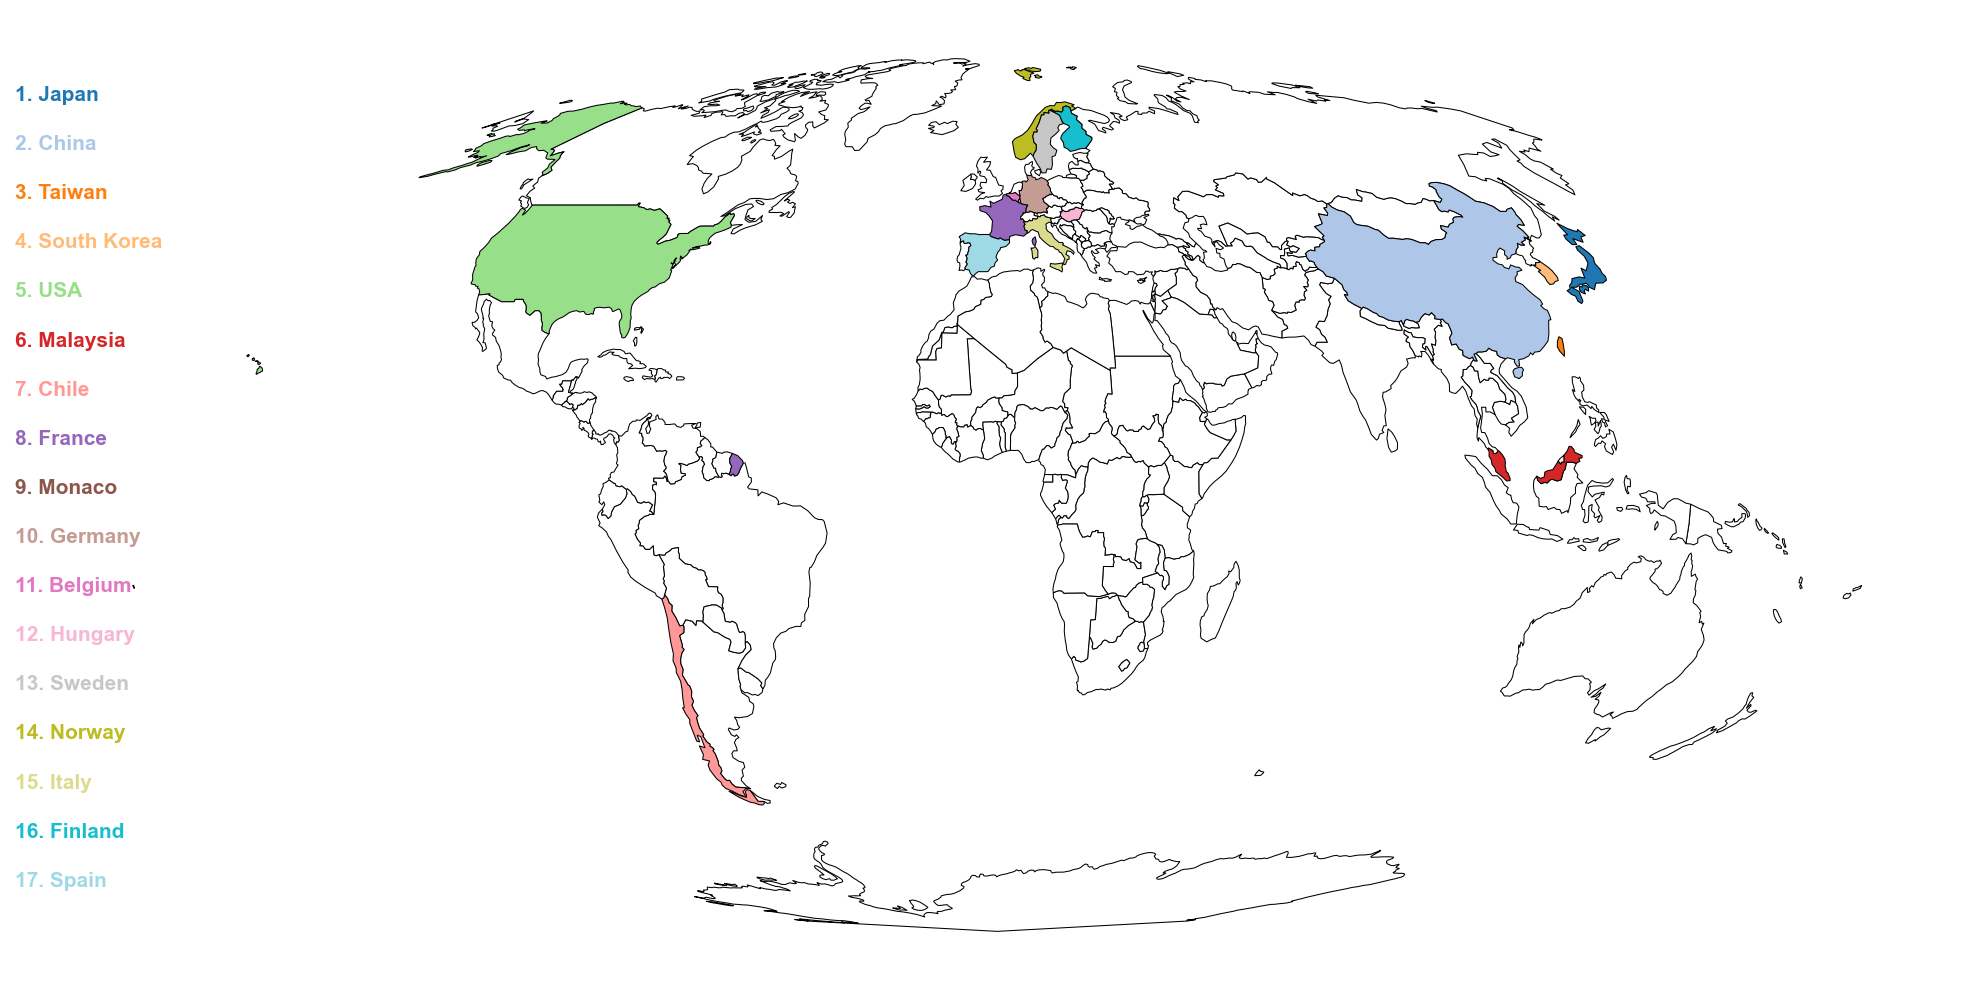

In [ ]:
# 1. Plot countries visited
countries_visited_1 = [
    "Japan (Osaka, Tokyo, Sapporo, Sendai, Naha)", "China (Hongkong, Makau)", "Taiwan (Taipei)", "South Korea (Seoul)", "USA (Honolulu)", 
    "USA (Hilo)", "Malaysia (Kuala Lumpur)", "USA (Houston)", "South Korea (Busan)", "Chile (Santiago, Antofagasta, Puerto Montt)", 
    "France (Nice)", "Monaco (Montecarlo)", "USA (Flagstaff)", "China (Tianjin, Beijing)", "France (Paris)",
    "USA (Hilo)", "Germany (Darmstadt, Düsseldorf, Köln)", "Belgium (Brussels)", "Germany (Munich)", "Hungary (Budapest)", 
    "Sweden (Stockholm)", "Norway (Oslo)", "Italy (Genova)", "Finland (Helsinki)", "Spain (Madrid)",
]
out_1 = "countries_visited.png"
plot_countries_visited(countries_visited_1, out_1)


Only in 1: Belgium, Chile, Hungary, Malaysia, Norway, Sweden, Taiwan
Only in 2: Australia, Cuba, Mexico, Philippines, Poland, Switzerland, Thailand, United Kingdom
In both: China, Finland, France, Germany, Italy, Japan, Monaco, South Korea, Spain, United States of America


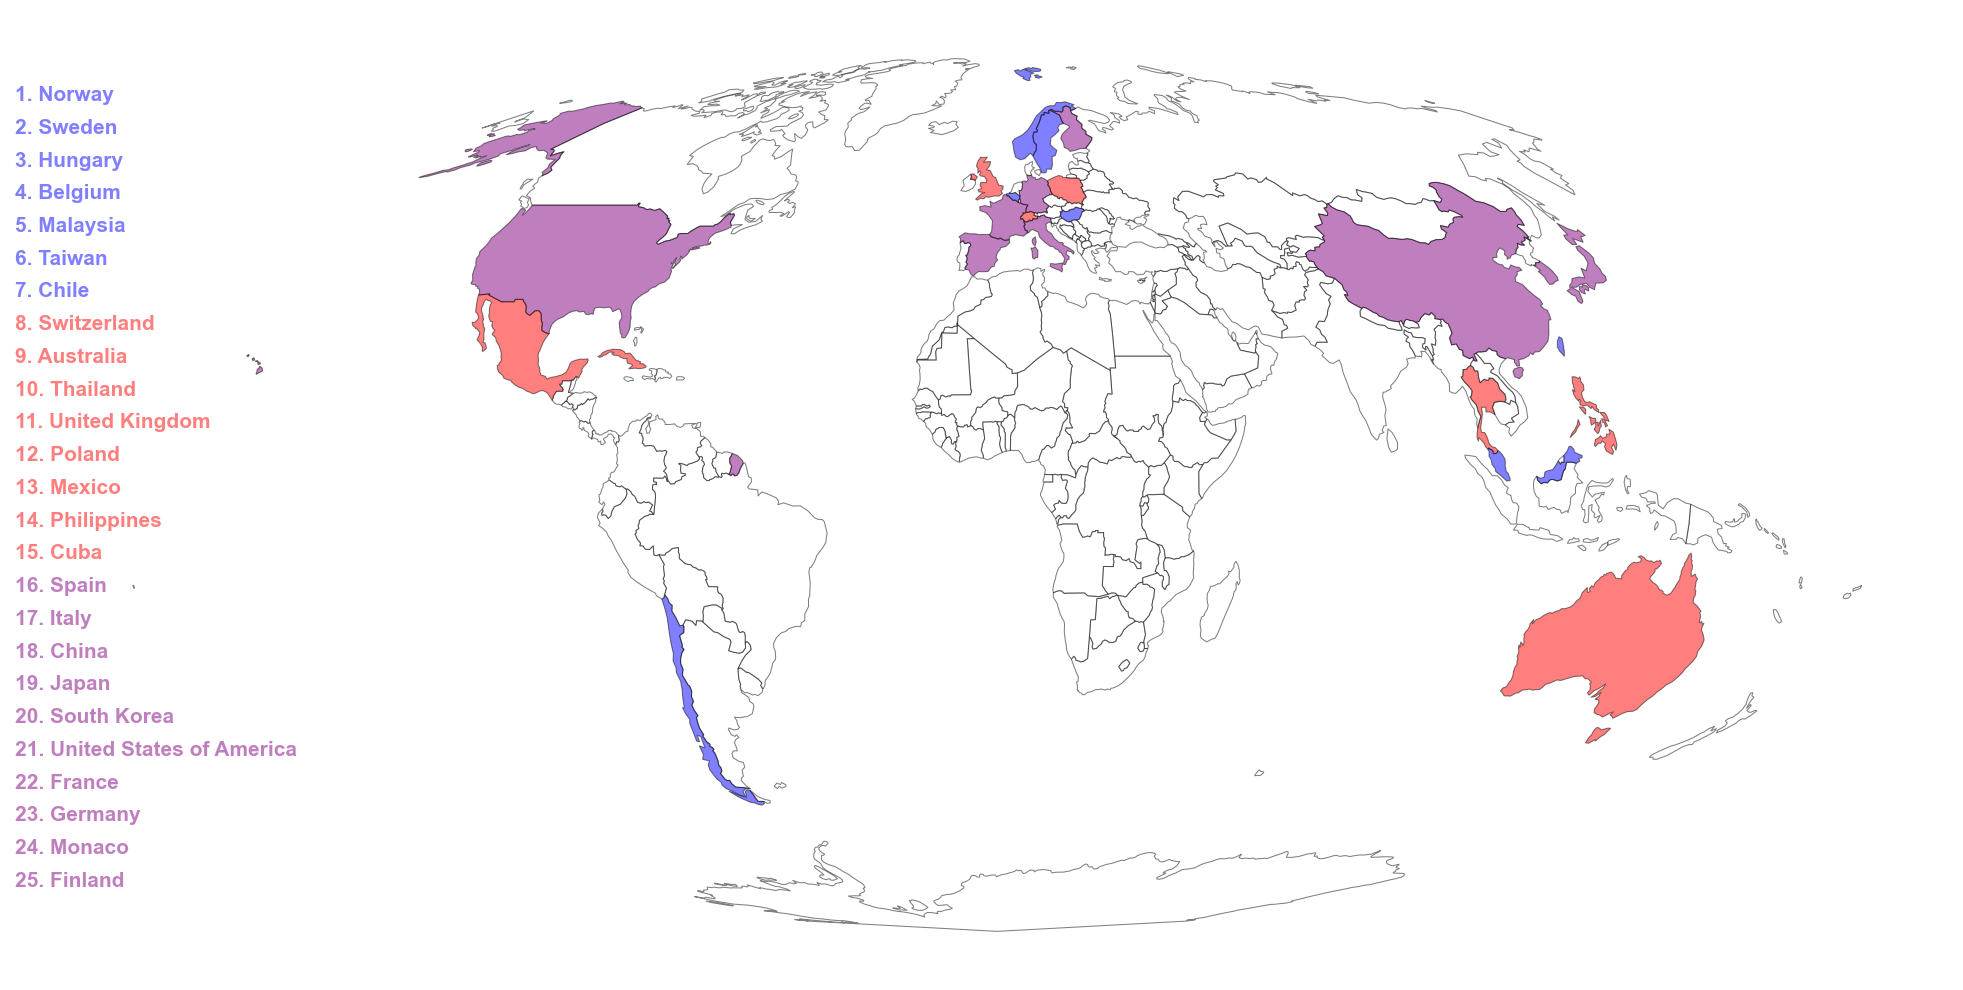

In [4]:
# 2. Plot countries visited for two with different colors
countries_visited_2 = [
    "Japan (Okinawa)", "Australia (Sydney)", "Australia (Melbourne)", "South Korea (Seoul)", "China (Beijing)", 
    "Philippines (Manila, Bohol)", "Thailand (Bangkok, Chiang Mai)", "France (Paris, Normandy, Rennes)", "UK (London, Edinburgh)", "Poland (Warsaw, Krakow)", 
    "Switzerland (Bern)", "Italy (Rome, Florence, Venice)", "Spain (Madrid, Barcelona, Granada)", "Mexico", "Cuba",
    "Germany", "Italy", "USA (San Francisco)", "South Korea (Seoul)", "South Korea (Seoul)", 
    "France (Nice)", "Monaco", "Italy (Genova)", "Finland (Helsinki)", "Spain (Madrid)"
]

# 2. Output filename
out_2 = "countries_visited_2.png"
out_2 = "countries_visited_2.pdf"

plot_countries_visited_2([countries_visited_1, countries_visited_2], ["blue", "red", "purple"], out=out_2)

/var/folders/xv/z4qp4sf50z10cwc8tgxysssw0000gn/T/ipykernel_95123/122272222.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20", len(visited_countries))


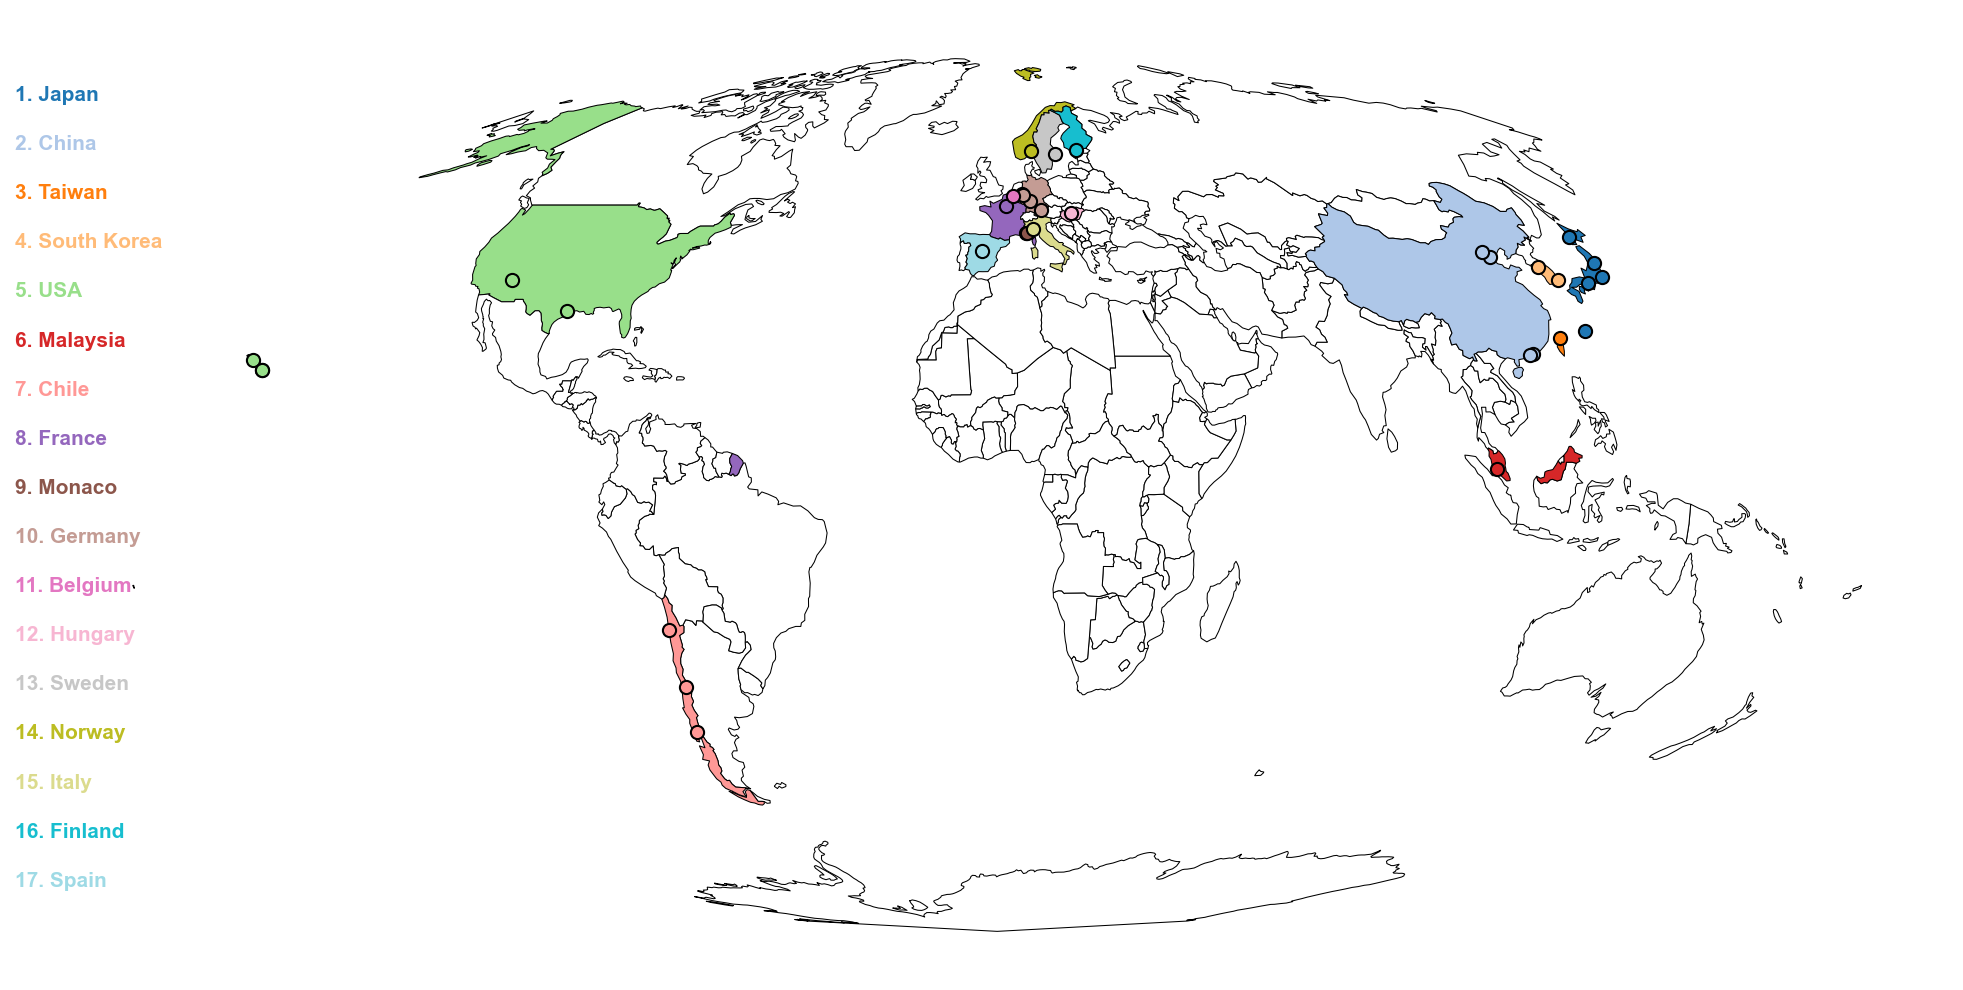

In [9]:
# 3. Plot countries and cities visited
countries_visited_1 = [
    "Japan (Osaka, Tokyo, Sapporo, Sendai, Naha)", "China (Hongkong, Makau)", "Taiwan (Taipei)", "South Korea (Seoul)", "USA (Honolulu)", 
    "USA (Hilo)", "Malaysia (Kuala Lumpur)", "USA (Houston)", "South Korea (Busan)", "Chile (Santiago, Antofagasta, Puerto Montt)", 
    "France (Nice)", "Monaco (Monte-carlo)", "USA (Flagstaff)", "China (Tianjin, Beijing)", "France (Paris)",
    "USA (Hilo)", "Germany (Darmstadt, Düsseldorf, Köln)", "Belgium (Brussels)", "Germany (Munich)", "Hungary (Budapest)", 
    "Sweden (Stockholm)", "Norway (Oslo)", "Italy (Genova)", "Finland (Helsinki)", "Spain (Madrid)",
]
out_1 = "countries_cities_visited.png"
plot_countries_visited(countries_visited_1, out_1, city=True)